In [4]:
import pickle


with open('spectra_list.pkl', 'rb') as f:
    spec = pickle.load(f)

In [5]:
import pandas as pd

Tem = pd.DataFrame(pd.read_csv('list_templates_10000.csv'))

In [6]:
X = [];

for i in range(spec['FLUX'].size):
    X.append(spec['FLUX'][i])

X = pd.DataFrame(X)

# Regressor SiIV

In [29]:
w_SiIV = [1397.61];
w_SiIV_z = []

for i in range(len(Tem['Z_QSO'])):
    w_SiIV_z.append([j*(1+Tem['Z_QSO'][i]) for j in w_SiIV])
    
w_SiIV_z = pd.DataFrame(w_SiIV_z, columns=['w_SiIV'])

In [30]:
y_SiIV = (w_SiIV_z-3671.5)/0.25

In [31]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(n_quantiles=1000, random_state=0)

X_sta = qt.fit_transform(X)
y_SiIV_sta = qt.fit_transform(y_SiIV)

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_SiIV_train, y_SiIV_test = train_test_split(X_sta, y_SiIV_sta, test_size=0.20, random_state=42)

In [90]:
import tensorflow as tf
from sklearn.multioutput import MultiOutputRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import QuantileTransformer
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
import torch
from keras.optimizers import Adam  
import time

device = tf.device('cuda')
#device = torch.device('cuda' if torch.backends.cuda.is_available() else 'cpu')  #Use GPU

AttributeError: module 'torch.backends.cuda' has no attribute 'is_available'

In [22]:
# set up the network hyperparameters
n_inputs = 23411
n_hidden1 = 10
n_hidden2 = 10
n_hidden3 = 10
n_outputs = 1
batch_norm_momentum = 0.9
#learning_rate = 0.001 # adam optimizer adapts the value of the learning rate
init = tf.keras.initializers.VarianceScaling(scale=1.0, mode='fan_in')
#centropy = tf.keras.losses.BinaryCrossentropy() #good for categorical data SparseCategoricalCrossentropy(from_logits=True)

# network structure
def base_model():
    nn_reg = tf.keras.models.Sequential([
      Dense(units=n_inputs, input_dim=n_inputs, kernel_initializer='normal', activation='relu'),
      Dense(n_hidden1, activation='relu', kernel_initializer='normal'),
      BatchNormalization(momentum=batch_norm_momentum, center=True, scale=True),
      Dense(n_hidden2, activation='relu', kernel_initializer='normal'),
      BatchNormalization(momentum=batch_norm_momentum, center=True, scale=True),
      Dense(n_hidden3, activation='relu', kernel_initializer='normal'),
      BatchNormalization(momentum=batch_norm_momentum, center=True, scale=True),
      Dense(n_outputs, kernel_initializer='normal')
    ])
    
    nn_reg.compile(loss='mean_absolute_error', optimizer='adam')#, metrics=['accuracy'])
#log_cosh
    return nn_reg

n_epochs = 8
batch_size = 50

clf_SiIV = KerasRegressor(build_fn=base_model, epochs=n_epochs, batch_size=batch_size ,verbose=1)   

C:\Users\Chenliang Su\AppData\Local\Temp\ipykernel_22392\1890448282.py:32: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf_SiIV = KerasRegressor(build_fn=base_model, epochs=n_epochs, batch_size=batch_size ,verbose=1)


In [23]:
start=time.time()

history_SiIV = clf_SiIV.fit(x=(X_train),y=(y_train), validation_data=(X_test,y_test))

# Print the time usage:
end = time.time()
print(f"Time used: {(end-start)*1000:.1f} ms")

Epoch 1/8
160/160 [==============================] - 843s 5s/step - loss: 0.3091 - val_loss: 0.1112
Epoch 2/8
160/160 [==============================] - 837s 5s/step - loss: 0.0704 - val_loss: 0.1130
Epoch 3/8
160/160 [==============================] - 838s 5s/step - loss: 0.0588 - val_loss: 0.0548
Epoch 4/8
160/160 [==============================] - 834s 5s/step - loss: 0.0541 - val_loss: 0.0427
Epoch 5/8
160/160 [==============================] - 834s 5s/step - loss: 0.0536 - val_loss: 0.0402
Epoch 6/8
160/160 [==============================] - 837s 5s/step - loss: 0.0554 - val_loss: 0.0456
Epoch 7/8
160/160 [==============================] - 833s 5s/step - loss: 0.0508 - val_loss: 0.0425
Epoch 8/8
160/160 [==============================] - 833s 5s/step - loss: 0.0516 - val_loss: 0.0441
Time used: 6775952.2 ms


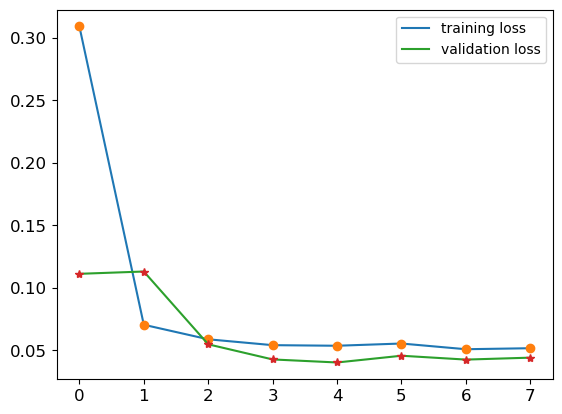

In [24]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm

training_loss = history_SiIV.history['loss']
validation_loss = history_SiIV.history['val_loss']

fig =  plt.figure()
plt.plot(training_loss,label = 'training loss')
plt.plot(training_loss,'o')
plt.plot(validation_loss, label = 'validation loss')
plt.plot(validation_loss, '*')
plt.legend()
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()

# Save and load models

In [28]:
clf_SiIV.model.save('saved_model/TensorFlowRegressor_SiIV')

INFO:tensorflow:Assets written to: saved_model/TensorFlowRegressor_lya\assets


INFO:tensorflow:Assets written to: saved_model/TensorFlowRegressor_lya\assets


INFO:tensorflow:Assets written to: saved_model/TensorFlowRegressor_SiIV\assets


INFO:tensorflow:Assets written to: saved_model/TensorFlowRegressor_SiIV\assets


In [3]:
import tensorflow as tf

clf_SiIV = tf.keras.models.load_model('saved_model/TensorFlowRegressor_SiIV')

In [21]:
clf_SiIV.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 23411)             548098332 
                                                                 
 dense_6 (Dense)             (None, 10)                234120    
                                                                 
 batch_normalization_3 (Batc  (None, 10)               40        
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 batch_normalization_4 (Batc  (None, 10)               40        
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 10)               

# Evaluate the model

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
from lightgbm import early_stopping
from scipy.stats import gaussian_kde

In [22]:
y_pred_SiIV=clf_SiIV.predict(X_test)

63/63 [==============================] - 12s 193ms/step


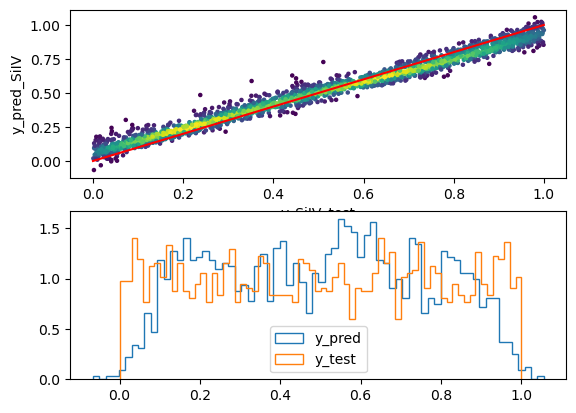

In [55]:
x = np.linspace(0,1,100)
y = x

# Calculate the point density
xy = np.vstack([y_SiIV_test[:,0],y_pred_SiIV[:,0]])
z = gaussian_kde(xy)(xy)

fig, axs = plt.subplots(2)
axs[0].scatter(y_SiIV_test,y_pred_SiIV, c=z, s=5)
axs[0].plot(x, y, '-r')
axs[0].set_xlabel('y_SiIV_test')
axs[0].set_ylabel('y_pred_SiIV')
axs[1].hist(y_pred_SiIV, alpha=1 ,histtype='step', density=True, bins=70, label='y_pred')
axs[1].hist(y_SiIV_test,alpha=1 ,histtype='step', density=True, bins=70, label='y_test')
axs[1].legend()

## Plot with original data

In [66]:
y_pred_SiIV_inv = qt.inverse_transform(y_pred_SiIV)
y_pred_SiIV_org = y_pred_SiIV_inv*0.25+3671.5

y_SiIV_test_inv = qt.inverse_transform(y_SiIV_test)
y_SiIV_test_org = y_SiIV_test_inv*0.25+3671.5

C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


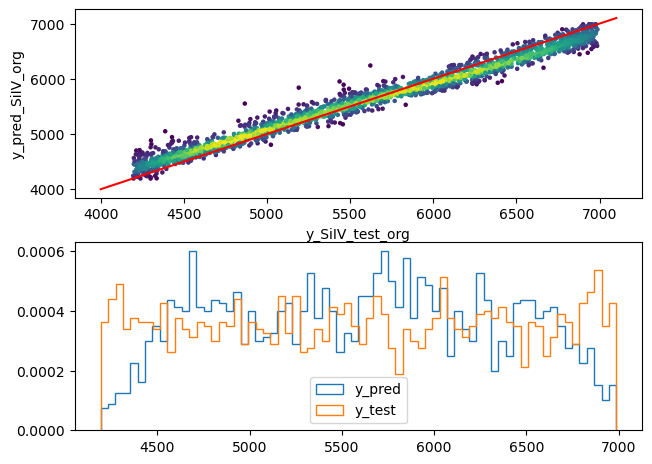

In [78]:
x = np.linspace(4000,7100,100)
y = x

# Calculate the point density
xy = np.vstack([y_SiIV_test_org[:,0],y_pred_SiIV_org[:,0]])
z = gaussian_kde(xy)(xy)

fig, axs = plt.subplots(2)
fig.tight_layout()
axs[0].scatter(y_SiIV_test_org,y_pred_SiIV_org, c=z, s=5)
axs[0].plot(x, y, '-r')
axs[0].set_xlabel('y_SiIV_test_org')
axs[0].set_ylabel('y_pred_SiIV_org')
axs[1].hist(y_pred_SiIV_org, alpha=1 ,histtype='step', density=True, bins=70, label='y_pred')
axs[1].hist(y_SiIV_test_org,alpha=1 ,histtype='step', density=True, bins=70, label='y_test')
axs[1].legend()